<a href="https://colab.research.google.com/github/MathCG19/FraudDetect/blob/main/DataAnalyticsFraudDetect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Qual a impotância de detectar fraudes em tempo hábil em sistemas financeiros?

- Detectar fraudes em tempo hábil é essencial para minimizar prejuízos financeiros, proteger os dados e o dinheiro dos clientes e manter a integridade e a confiança no sistema financeiro. Quanto mais rápido a fraude é identificada, maior a chance de bloqueá-la antes que cause danos maiores.


- Meu objetivo é construir um fluxo eficiente, capaz de identificar padrões que indiquem fraudes de forma confiável e sem viéses.

# Detecção de Fraudes com K-NN

Neste notebook, desenvolvi um modelo de Machine Learning utilizando o algoritmo **K-Vizinhos Mais Próximos (K-NN)** para detectar transações fraudulentas em cartões de crédito.

1. **Importações** – apenas ferramentas utilizadas no código.
2. **Amostragem aleatória** – selecionei **200.000 linhas aleatórias** do total de 1 milhão, utilizando a função `sample()` do pandas com `random_state` para garantir que seja aleatório.
3. **Intervalo de K amplo** – o número de vizinhos de 5 em 5 (de 5 até 50) para observar os impactos que tenho na acurácia.


## 1. Importação das bibliotecas

Nesta etapa importei apenas as bibliotecas mais **necessárias** para cada parte do projeto, para não desperdiçar processamento nem espaço:

- `pandas`: para manipulação da base de dados.
- `StandardScaler`: para normalizar os dados e garantir que todas as variáveis estejam na mesma escala.
- `train_test_split`: para dividir os dados em treino e teste.
- `KNeighborsClassifier`: o modelo de aprendizado supervisionado baseado em proximidade.
- `accuracy_score`, `confusion_matrix`, `ConfusionMatrixDisplay`: métricas de desempenho.
- `matplotlib.pyplot`: para gerar gráficos informativos.
- `seaborn`: para a melhor visualização dos dados

In [ ]:
# Bibliotecas usadas
import pandas as pd  # manipulação de dados com tabelas
from sklearn.preprocessing import StandardScaler  # normalização dos dados numéricos
from sklearn.model_selection import train_test_split  # separação entre dados de treino e teste
from sklearn.neighbors import KNeighborsClassifier  # algoritmo de classificação K-NN
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay  # métricas de avaliação
import matplotlib.pyplot as plt  # criação de gráficos
import seaborn as sns  # visualização de dados


# 2. Estrutura e balanceamento dos dados

Nesta etapa, eu estou fazendo uma **verificação da estrutura geral do dataset** usando `info()` e `head()`, o que faz eu conseguir ver o número de colunas e registros, também visualizar as primeiras linhas da base.

Em seguida, eu analiso o **balanceamento da variável alvo** (`fraud`), que indica se uma transação é fraudulenta (`1`) ou legítima (`0`), para isso eu uso método `value_counts()` do pandas.

Por fim, eu gero um **gráfico de barras** com `seaborn` para visualizar a **distribuição das classes**, destacando o desbalanceamento desse tipo de problema — com muito mais transações **legítimas** do que **fraudulentas**.

Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  float64
 4   used_chip                       1000000 non-null  float64
 5   used_pin_number                 1000000 non-null  float64
 6   online_order                    1000000 non-null  float64
 7   fraud                           1000000 non-null  float64
dtypes: float64(8)
memory usage: 61.0 MB
None
Primeiras linhas:
   distance_from_home  distance_from_last_transaction  \
0           57.877857                        0.311140   
1           10.829943                        0.175

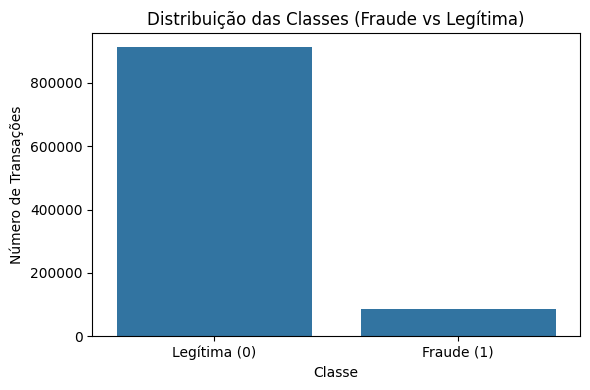

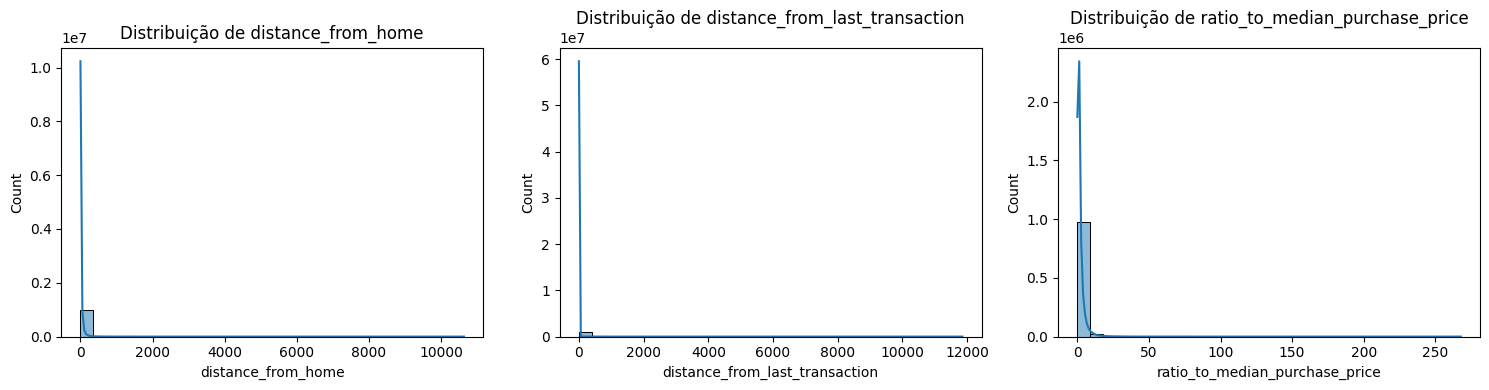

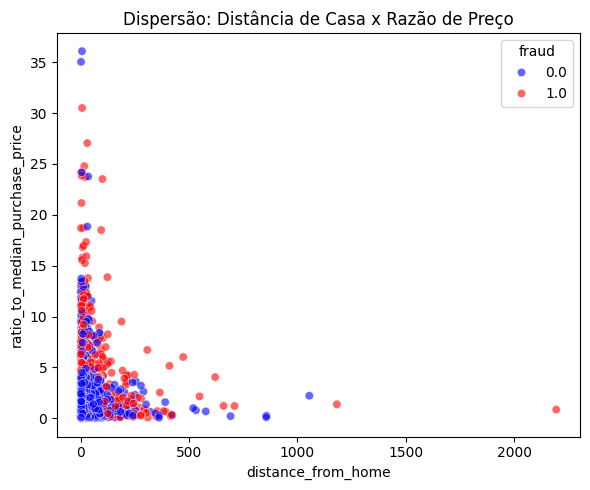

In [ ]:
# Carregar o dataset
df = pd.read_csv('card_transdata.csv')  # Substitua com o caminho correto se necessário

# Verificar estrutura do dataset
print("Informações gerais do dataset:")
print(df.info())
print("Primeiras linhas:")
print(df.head())

# Verificar balanceamento das classes
class_counts = df['fraud'].value_counts()
class_proportion = df['fraud'].value_counts(normalize=True)

print("Contagem das classes:")
print(class_counts)
print("Proporção das classes:")
print(class_proportion)

# Gráfico de barras da distribuição das classes
plt.figure(figsize=(6, 4))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribuição das Classes (Fraude vs Legítima)')
plt.xticks([0, 1], ['Legítima (0)', 'Fraude (1)'])
plt.ylabel('Número de Transações')
plt.xlabel('Classe')
plt.tight_layout()
plt.show()

# Análise da distribuição das variáveis principais
main_vars = [
    'distance_from_home',
    'distance_from_last_transaction',
    'ratio_to_median_purchase_price'
]

# Histograma das variáveis principais
plt.figure(figsize=(15, 4))
for i, var in enumerate(main_vars):
    plt.subplot(1, 3, i + 1)
    sns.histplot(data=df, x=var, bins=30, kde=True)
    plt.title(f'Distribuição de {var}')
plt.tight_layout()
plt.show()

# Gráfico de dispersão: distância x razão de compra
plt.figure(figsize=(6, 5))
sns.scatterplot(
    data=df.sample(5000),  # amostra para facilitar visualização
    x='distance_from_home',
    y='ratio_to_median_purchase_price',
    hue='fraud',
    alpha=0.6,
    palette={0: 'blue', 1: 'red'}
)
plt.title('Dispersão: Distância de Casa x Razão de Preço')
plt.tight_layout()
plt.show()


## 3. Carregamento e amostragem dos dados

Como treinar com 1 milhão de linhas pode ser pesado em tempo e memória, **utilizei a função `sample()` do pandas** para selecionar **200.000 linhas aleatórias**, definindo um `random_state` para garantir que os resultados possam ser reproduzidos depois. Isso também ajuda a evitar que os dados fiquem enviesados com alguma ordem pré-existente no CSV.

In [ ]:
# Seleciona 200 mil linhas aleatórias do total de 1 milhão
df_sample = df.sample(n=200000, random_state=42)  # garante que seja aleatório


In [ ]:
# Verificar valores ausentes
print("Valores ausentes por coluna:")
print(df.isnull().sum())

Valores ausentes por coluna:
distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64


## 4. Pré-processamento dos dados

Aqui preparo os dados para o treinamento:

- Separei o **(`y`)**, que é a coluna `fraud`, e as **features (`X`)**, que são todas as outras colunas.
- Utilizei o `StandardScaler()` do `sklearn` para **normalizar os dados**. Isso é essencial para o K-NN, por que ele depende de distâncias.
- Dividi os dados em **70% treino e 30% teste** com `train_test_split()`,  garantindo com o `stratify` que as classes sejam proporcionais.

In [ ]:
# Define a variável alvo (y) e as features (X)
y = df_sample['fraud']  # coluna alvo indicando fraude ou não
X = df_sample[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price', 'used_pin_number', 'online_order']]  # colunas mais informativas

# Normaliza as variáveis com StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # transforma os dados para ter média 0 e desvio padrão 1

# Divide os dados em treino (70%) e teste (30%), mantendo proporção de classes
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)


In [ ]:
#Verifico tipos de dados para garantir que são compatíveis
print("\nTipos de dados das colunas:")
print(X.dtypes)


Tipos de dados das colunas:
distance_from_home                float64
distance_from_last_transaction    float64
ratio_to_median_purchase_price    float64
used_pin_number                   float64
online_order                      float64
dtype: object


## 5. Treinamento do modelo K-NN

Aqui eu testo o desempenho do modelo variando o número de vizinhos (K) de **5 em 5, de 5 até 50**. Isso ajuda a entender qual K produz os melhores resultados.

Para cada valor de K:
- Treino o modelo com os dados de treino.
- Faço previsões com os dados de teste.
- Calculo a acurácia com `accuracy_score`.

Guardo tudo em uma lista para depois plotar e encontrar o **melhor valor de K**.

In [ ]:
# Teste de múltiplos valores de K
valores_k = list(range(5, 51, 5))  # gera lista de K de 5 a 50, pulando de 5 em 5
acuracias = []

for k in valores_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acuracias.append(accuracy_score(y_test, y_pred))  # salva a acurácia para esse K

# Descobre o melhor K
melhor_k = valores_k[acuracias.index(max(acuracias))]
print(f"Melhor K: {melhor_k}  |  Acurácia: {max(acuracias):.4f}")

# Treina modelo final com o melhor K
knn_final = KNeighborsClassifier(n_neighbors=melhor_k)
knn_final.fit(X_train, y_train)
y_pred_final = knn_final.predict(X_test)


Melhor K: 25  |  Acurácia: 0.9839


## 6. Avaliação visual e matriz de confusão

Gera:
- Um **gráfico** que mostra como a acurácia varia conforme o número de vizinhos (K).
- A **matriz de confusão**, que mostra os acertos e erros do modelo final com o melhor K.

Esses resultados ajudam a entender a performance do modelo em detectar fraudes.

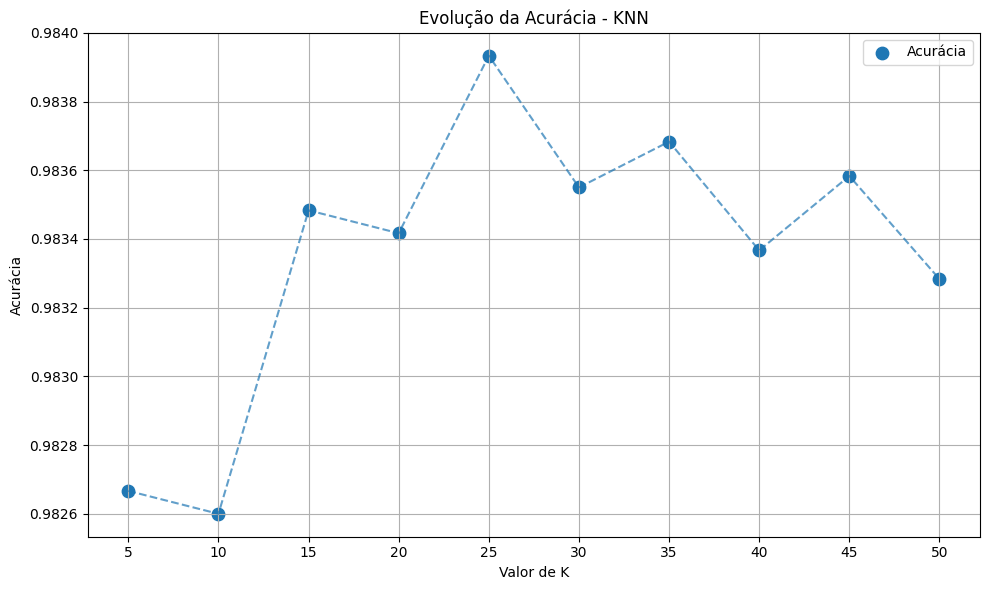

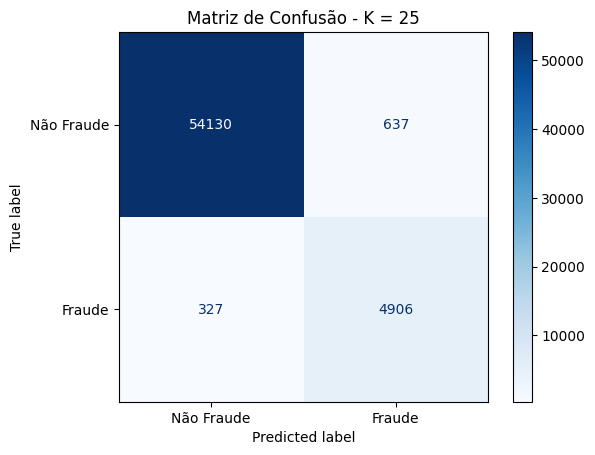

In [ ]:
# Gráfico de acurácia por K
plt.figure(figsize=(10,6))
plt.scatter(valores_k, acuracias, label='Acurácia', s=80)
plt.plot(valores_k, acuracias, linestyle='--', alpha=0.7)
plt.title('Evolução da Acurácia - KNN')
plt.xlabel('Valor de K')
plt.ylabel('Acurácia')
plt.xticks(valores_k)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Matriz de confusão do modelo final
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_final), display_labels=['Não Fraude', 'Fraude'])
disp.plot(cmap='Blues')
plt.title(f'Matriz de Confusão - K = {melhor_k}')
plt.grid(False)
plt.show()


## Conclusão

Ao longo deste notebook, meu objetivo foi aplicar um modelo simples, porém funcional, para detectar fraudes em transações de cartão de crédito. Desde o início, quis montar um fluxo coerente, explicando cada passo, desde o carregamento e análise da base até a construção e avaliação do modelo com KNN (K-Nearest Neighbors). Escolhi esse algoritmo por ser fácil de entender e por funcionar bem em problemas supervisionados com dados não lineares.

Fiz uma amostragem aleatória do dataset original utilizando 200.000 linhas, no caso, df.sample(n=200000, random_state=42) para conseguir trabalhar com um volume mais leve. Para preparar os dados, apliquei o StandardScaler() para normalizar as variáveis numéricas, evitando que diferenças de escala entre os atributos interferissem nos resultados do modelo. A divisão entre treino e teste foi feita com train_test_split(), garantindo uma separação justa para avaliar o desempenho do algoritmo.

Durante a parte de modelagem, usei o KNeighborsClassifier() variando o número de vizinhos (n_neighbors) de 5 em 5, até 50, para avaliar o impacto do parâmetro K na acurácia do modelo. Também calculei a acurácia com accuracy_score() e observei visualmente os resultados usando matplotlib.pyplot para plotar os gráficos comparativos.

Ao longo do caminho, deixei comentários explicativos em cada célula de código, com o intuito de manter o notebook organizado e didático. Além disso, tirei dúvidas com o ChatGPT em vários momentos sobre:

- O impacto da normalização com o StandardScaler,

- A lógica por trás do train_test_split,

- A importância do balanceamento de classes,

- E como interpretar o comportamento do modelo KNN em relação ao aumento do número de vizinhos.

Essas interações me ajudaram a reforçar o entendimento dos conceitos de overfitting, underfitting, balanceamento de classes e avaliação de desempenho, assim aprendendo a utilizar a IA para alinhar ela de forma mais eficaz com meus objetivos e não um copia e cola.

Mesmo sendo um modelo simples, o KNN aprendeu sim a identificar padrões de fraude. Ele se mostrou capaz de generalizar minimamente, o que ficou evidente nas curvas de acurácia ao longo dos diferentes valores de K. Claro que, para um cenário real, seria necessário aplicar melhorias como:

- Técnicas de balanceamento (por exemplo, SMOTE ou undersampling),

- Uso de modelos mais robustos como RandomForestClassifier ou XGBoost,

- Além de uma validação cruzada mais refinada com cross_val_score.

Mas, dentro do escopo proposto, acredito que o objetivo foi atingido com sucesso. O modelo foi planejado, treinado, testado e avaliado com lógica e clareza. E o mais importante: aprendi o caminho necessário para aplicar machine learning em problemas reais, mesmo começando com uma base mais simples e um modelo básico. Isso me dá segurança para explorar modelos mais avançados e datasets mais desafiadores futuramente.